# M1 Coursework

Yuanzhen Zhao (yz929)

## Question 1

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam #optimisers
from tensorflow.keras.utils import to_categorical #some function for data preparation

In [3]:
batch_size = 128
num_classes = 19
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [4]:
images = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

np.random.seed(114514)

In [5]:
def create_combined_dataset(images, labels, dataset_size=10000):
    combined_images = []
    combined_labels = []
    
    for _ in range(dataset_size):
        idx1, idx2 = np.random.choice(np.arange(len(images)), 2, replace=True)
        img1, img2 = images[idx1], images[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        combined_image = np.hstack((img1, img2))
        combined_label = label1 + label2
        
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        
    combined_images = np.array(combined_images).reshape(-1, 28, 56, 1)
    combined_labels = np.array(combined_labels)
    
    return combined_images, combined_labels

In [6]:
dataset_size = 100000
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

print("Train size: ", train_size)
print("Validation size: ", val_size)
print("Test size: ", test_size)

Train size:  60000
Validation size:  20000
Test size:  20000


In [7]:
combined_images, combined_labels = create_combined_dataset(images, labels, dataset_size)

(28, 56, 1)
10


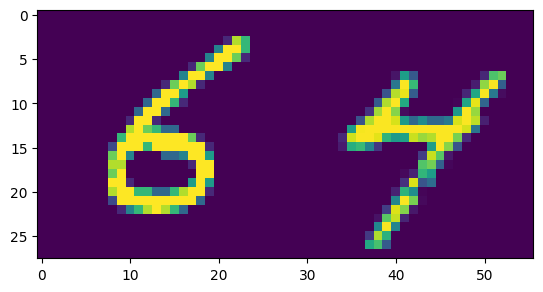

In [8]:
print(combined_images[0].shape)
print(combined_labels[0])
plt.imshow(combined_images[0])

In [9]:
# Split dataset
train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]

In [10]:
train_labels_categorical = to_categorical(train_labels, num_classes)
val_labels_categorical = to_categorical(val_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

In [11]:
print("Train images shape: ", train_images.shape)
print("Validation images shape: ", val_images.shape)
print("Test images shape: ", test_images.shape)

Train images shape:  (60000, 28, 56, 1)
Validation images shape:  (20000, 28, 56, 1)
Test images shape:  (20000, 28, 56, 1)


## Question 2

In [13]:
def objective(trial):
    # Suggest values for hyperparameters
    num_units_layer1 = trial.suggest_int("units_layer1", 256, 512, step=32)
    num_units_layer2 = trial.suggest_int("units_layer2", 256, 512, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    # Build the model
    model = Sequential([
        Input(shape=(28, 56, 1)),
        Flatten(),
        Dense(num_units_layer1, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units_layer2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_images, train_labels_categorical,
        validation_data=(val_images, val_labels_categorical),
        epochs=20,  # Use a small number of epochs for tuning
        batch_size=batch_size,
        verbose=0  # Suppress output for faster tuning
    )
    
    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
    return -val_accuracy


In [14]:
# Create a study and optimize the objective function
storage = "sqlite:///study.db"
study = optuna.create_study(direction="minimize", storage=storage, load_if_exists=True)
study.optimize(objective, n_trials=20)  # Run 30 trials

best_params = study.best_params
best_accuracy = -study.best_value  # Negate the value to get accuracy
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

[I 2024-12-05 19:23:13,512] A new study created in RDB with name: no-name-be476ae8-0c4e-43a3-ad81-d59371865805
[I 2024-12-05 19:23:34,374] Trial 0 finished with value: -0.911300003528595 and parameters: {'units_layer1': 352, 'units_layer2': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0010655980518211737, 'batch_size': 256}. Best is trial 0 with value: -0.911300003528595.
[I 2024-12-05 19:23:54,094] Trial 1 finished with value: -0.9176499843597412 and parameters: {'units_layer1': 384, 'units_layer2': 288, 'dropout_rate': 0.1, 'learning_rate': 0.0014442768548183693, 'batch_size': 256}. Best is trial 1 with value: -0.9176499843597412.
[I 2024-12-05 19:24:17,578] Trial 2 finished with value: -0.9264000058174133 and parameters: {'units_layer1': 384, 'units_layer2': 512, 'dropout_rate': 0.1, 'learning_rate': 0.002212889157541357, 'batch_size': 256}. Best is trial 2 with value: -0.9264000058174133.
[I 2024-12-05 19:24:36,525] Trial 3 finished with value: -0.9190000295639038 and parameters: {

Best parameters: {'units_layer1': 448, 'units_layer2': 416, 'dropout_rate': 0.4, 'learning_rate': 0.0030819124181364873, 'batch_size': 512}
Best validation accuracy: 0.9285


In [21]:
# Build the best model with the optimized parameters
best_model = Sequential([
    Flatten(input_shape=(28, 56, 1)),
    Dense(best_params['units_layer1'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_layer2'], activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [22]:
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the best model on the full training set
best_model.fit(
    train_images, train_labels_categorical,
    validation_data=(val_images, val_labels_categorical),
    epochs=20,
    batch_size=best_params['batch_size']
)

test_loss, test_accuracy = best_model.evaluate(test_images, test_labels_categorical)

print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2343 - loss: 2.3234 - val_accuracy: 0.6822 - val_loss: 1.0234
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6467 - loss: 1.1004 - val_accuracy: 0.7878 - val_loss: 0.7025
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7411 - loss: 0.8278 - val_accuracy: 0.8213 - val_loss: 0.5886
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7835 - loss: 0.7053 - val_accuracy: 0.8480 - val_loss: 0.5107
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8135 - loss: 0.6146 - val_accuracy: 0.8655 - val_loss: 0.4564
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8319 - loss: 0.5533 - val_accuracy: 0.8763 - val_loss: 0.4243
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8432 - loss: 0.5122 - val_accuracy: 0.8845 - val_loss: 0.3971
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8533 - loss: 0.4778 - val_accuracy: 0.

## Question 3

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
# A smaller dataset for unsupervised learning

dataset_size = 20000
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

combined_images, combined_labels = create_combined_dataset(images, labels, dataset_size)

train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]

In [23]:
# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [24]:
train_images_flat.shape, test_images_flat.shape

((30000, 1568), (10000, 1568))

In [ ]:
# Random Forest Classifier
# This cell takes around 3 mins to run

RndFrstClass = RandomForestClassifier(n_estimators=500, max_depth=30)
RndFrstClass.fit(train_images_flat, train_labels)
RndFrstPred = RndFrstClass.predict(test_images_flat)

RFC_model_accuracy = accuracy_score(test_labels, RndFrstPred)
print(f"Accuracy of Random Forest Classifier: {RFC_model_accuracy}")

Accuracy of Random Forest Classifier: 0.7822


In [ ]:
# Support Vector Classifier

svcClass = SVC()
svcClass.fit(train_images_flat, train_labels) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = accuracy_score(test_labels, svcPred)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")

Accuracy of Support Vector Classifier: 0.10035


In [ ]:
# SVC with RBF kernel
# This cell takes around 39 mins to run
svcClass = SVC(kernel='rbf')
svcClass.fit(train_images_flat, train_labels) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = accuracy_score(test_labels, svcPred)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")

## Question 4

In [16]:
from sklearn.linear_model import LogisticRegression

In [43]:
def train_single_classifier(X_train, y_train, X_test, y_test):
    # Flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    logreg = LogisticRegression(max_iter=2000)
    logreg.fit(X_train_flat, y_train)
    
    y_pred = logreg.predict(X_test_flat)
    
    acc = accuracy_score(y_test, y_pred)
    return acc

In [44]:
def train_two_classifiers(X_train, y_train, X_test, y_test):
    # Split the combined images into two halves
    X_train_first, X_train_second = X_train[:, :, :28, :], X_train[:, :, 28:, :]
    X_test_first, X_test_second = X_test[:, :, :28, :], X_test[:, :, 28:, :]
    
    # Flatten the images
    X_train_first = X_train_first.reshape(X_train_first.shape[0], -1)
    X_train_second = X_train_second.reshape(X_train_second.shape[0], -1)
    X_test_first = X_test_first.reshape(X_test_first.shape[0], -1)
    X_test_second = X_test_second.reshape(X_test_second.shape[0], -1)
    
    logreg1 = LogisticRegression(max_iter=2000)
    logreg1.fit(X_train_first, y_train)
    y_pred1 = logreg1.predict(X_test_first)
    
    logreg2 = LogisticRegression(max_iter=2000)
    logreg2.fit(X_train_second, y_train)
    y_pred2 = logreg2.predict(X_test_second)
    
    y_pred = y_pred1 + y_pred2
    
    acc = accuracy_score(y_test, y_pred)
    return acc

In [45]:
sample_sizes = [50, 100, 500, 1000]
results_single = []
results_two = []

In [46]:
for size in sample_sizes:
    # Sample a subset for training
    train_images_subset, train_labels_subset = train_images[:size], train_labels[:size]
    
    # Method 1: Single classifier on 56x28
    acc_single = train_single_classifier(train_images_subset, train_labels_subset, test_images, test_labels)
    results_single.append((size, acc_single))
    
    # Method 2: Two classifiers on 28x28 parts
    acc_two = train_two_classifiers(train_images_subset, train_labels_subset, test_images, test_labels)
    results_two.append((size, acc_two))

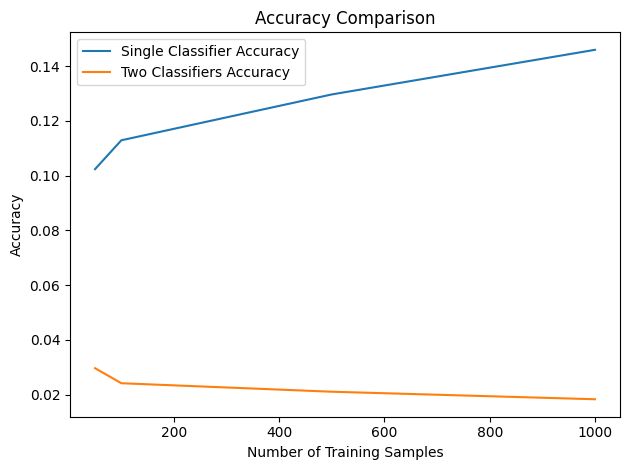

In [47]:
# Visualize results
results_single = np.array(results_single)
results_two = np.array(results_two)

plt.figure()

plt.plot(results_single[:, 0], results_single[:, 1], label="Single Classifier Accuracy")
plt.plot(results_two[:, 0], results_two[:, 1], label="Two Classifiers Accuracy")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()

## Question 5

In [12]:
from sklearn.manifold import TSNE

In [27]:
best_model.pop(rebuild=True)
embeddings = best_model.predict(train_images)
tsne = TSNE(n_components=2, random_state=42, perplexity=20, learning_rate=200)
reduced_embeddings = tsne.fit_transform(embeddings)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step


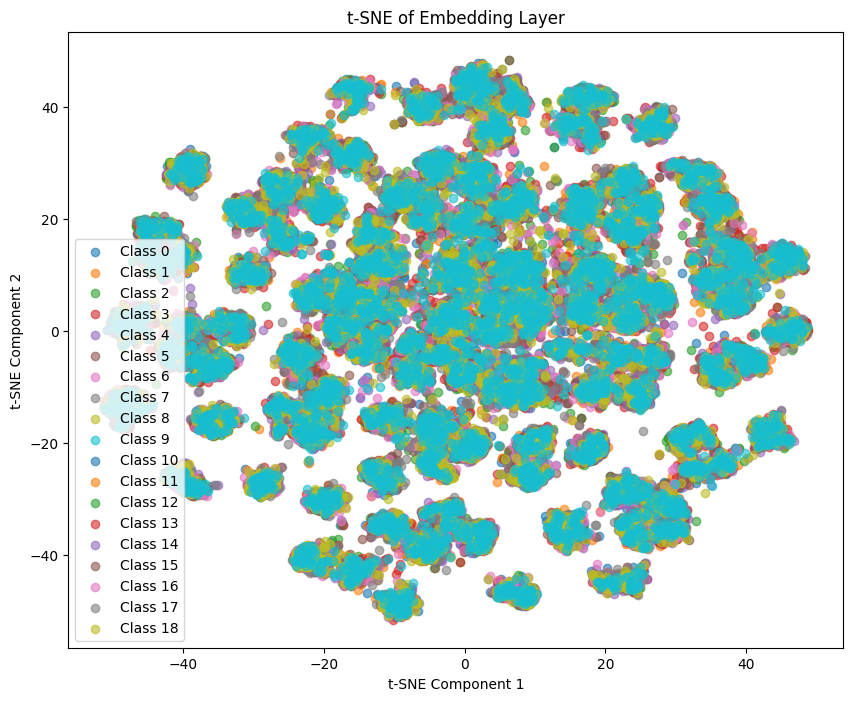

In [32]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    idx = np.where(y_train == i)
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Class {i}", alpha=0.6)

plt.title("t-SNE of Embedding Layer")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

In [15]:
train_images_flat = train_images.reshape(train_images.shape[0], -1)
tsne_input = TSNE(n_components=2, perplexity=20, random_state=42)
train_images_embedded = tsne_input.fit_transform(train_images_flat)

C:\Users\JZ\AppData\Local\Temp\ipykernel_34904\4004874756.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


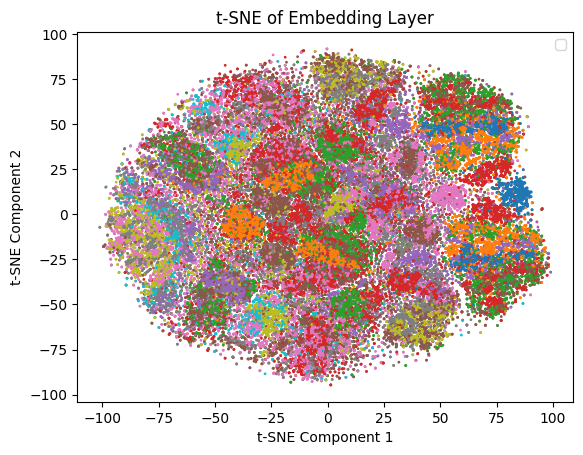

In [17]:
plt.scatter(train_images_embedded[:, 0],train_images_embedded[:, 1], c=train_labels.astype(int), cmap='tab10', s=1)
plt.title("t-SNE of Embedding Layer")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()